# Imports

In [1]:
import math
import numpy as np
import pytest
import torch
import triton
import triton.language as tl
import matplotlib.pyplot as plt

# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    red, green, blue = tableau20[i]
    tableau20[i] = (red / 255., green / 255., blue / 255.)

In [3]:
!nvidia-smi

Thu Jun  1 21:55:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   29C    P0    54W / 400W |      2MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Hash-sparse kernel

In [2]:
@triton.jit
def _fwd_kernel_hash(
    Q, K, V, sm_scale, 
    Out,
    sqz, sqh, sqm, sqd, # shape = (Z,H,N_CTX_Q,D)
    skz, skh, skn, skd, # shape = (Z,H,N_CTX_KV,D)
    svz, svh, svn, svd, # shape = (Z,H,N_CTX_KV,D)
    soz, soh, som, sod, # shape = (Z,H,N_CTX_Q,D)
    Q_idx, K_idx, 
    sqiz, sqih, sqim,  # shape = (Z,H,N_CTX_Q)
    skiz, skih, skin,  # shape = (Z,H,N_CTX_KV)
    Q_hash, K_hash, 
    sqhz, sqhh, sqhm,  # shape = (Z,H,N_CTX_Q)
    skhz, skhh, skhn,  # shape = (Z,H,N_CTX_KV)
    L, M,
    Z, H, N_CTX_Q, N_CTX_KV, 
    BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, # will load BLOCK_M queries, and compute self attention by blocks of BLOCK_N keys
    BLOCK_DMODEL: tl.constexpr # dimensionality of heads: D
):
    start_m = tl.program_id(0) # idx of sequence length chunk of size 128 (BLOCK_N)
    off_hz = tl.program_id(1) # idx of head_batch (unique idx for each head in each batch)

    # initialize offsets
    offs_m = start_m * BLOCK_M + tl.arange(0, BLOCK_M) # indices of queries we want to process
    offs_n = tl.arange(0, BLOCK_N) # indices of keys we want to process, we start from [0, BLOCK_N-1] and update in the loop
    offs_d = tl.arange(0, BLOCK_DMODEL) # we want to process all the dimensions of a given head

    offs_q = off_hz * sqh + offs_m[:, None] * sqm + offs_d[None, :] * sqd # Q.view(Z*H,N_CTX_Q,D)[off_hz, start_m*BLOCK_M:(start_m+1)*BLOCK_M, :].squeeze() that's a BLOCK_M*D matrix
    offs_qi = off_hz * sqih + offs_m * sqim # Q_idx.view(Z*H,N_CTX_Q)[off_hz, start_m*BLOCK_M:(start_m+1)*BLOCK_M] a vector of BLOCK_M indices 
    offs_qh = off_hz * sqhh + offs_m * sqhm  
    offs_kh = off_hz * skhh + offs_n * skhn 

    # pointers to m and l
    m_prev = tl.zeros([BLOCK_M], dtype=tl.float32) - float("inf") 
    l_prev = tl.zeros([BLOCK_M], dtype=tl.float32)
    acc = tl.zeros([BLOCK_M, BLOCK_DMODEL], dtype=tl.float32)

    # Load values
    qi_vals = tl.load(Q_idx + offs_qi, mask=offs_m < N_CTX_Q, other=-1)
    q_vals = tl.load(Q + offs_q, mask=qi_vals[:, None] >= 0) 
    qh_vals = tl.load(Q_hash + offs_qh, mask=offs_m < N_CTX_Q, other=1e9)
    min_q_hash = tl.min(qh_vals, axis=0)
    qh_vals = tl.where(offs_m < N_CTX_Q, qh_vals, -1)
    max_q_hash = tl.max(qh_vals, axis=0)

    end_n = 0
    start_n = 0

    # Increment the start and end to find start and end blocks 
    for _ in range(0, N_CTX_KV, BLOCK_N):
        kh_vals = tl.load(K_hash + offs_kh, mask=offs_n < N_CTX_KV, other=+1e9)
        min_kh = tl.min(kh_vals, axis=0)
        if min_kh <= max_q_hash and min_kh != 1e9:
            end_n += 1
        kh_vals = tl.where(offs_n < N_CTX_KV, kh_vals, -1e9)
        max_kh = tl.max(kh_vals, axis=0)
        if max_kh < min_q_hash and max_kh != -1e9:
            start_n += 1
        offs_n += BLOCK_N
        offs_kh += BLOCK_N * skhn

    # remove unecessary trailing blocks based on causal structure
    causal_end_n = end_n
    offs_n = BLOCK_N * start_n + tl.arange(0, BLOCK_N)
    offs_ki = off_hz * skih + offs_n * skin
    max_qi = tl.max(qi_vals, axis=0) # largest query index in block
    for i in range(start_n, end_n):
        ki_vals = tl.load(K_idx + offs_ki, mask=offs_n < N_CTX_KV, other=1e9)
        min_ki = tl.min(ki_vals, axis=0)
        if min_ki <= max_qi and min_ki != 1e9:
            causal_end_n = i + 1
        offs_ki += BLOCK_N * skin
        offs_n += BLOCK_N

    # re-initialize offsets
    offs_n = BLOCK_N * start_n + tl.arange(0, BLOCK_N) # indices of keys we want to process, we start from [0, BLOCK_N-1] and update in the loop
    offs_k = off_hz * skh + offs_n[None, :] * skn + offs_d[:, None] * skd # K.view(Z*H,N_CTX_KV,D)[off_hz, 0:BLOCK_N, :].transpose(1,2).squeeze() that's a D*BLOCK_N matrix
    offs_v = off_hz * svh + offs_n[:, None] * svn + offs_d[None, :] * svd # V.view(Z*H,N_CTX_KV,D)[off_hz, 0:BLOCK_N, :].squeeze() that's a BLOCK_N*D matrix
    offs_ki = off_hz * skih + offs_n * skin # K_idx.view(Z*H,N_CTX_KV)[off_hz, 0:BLOCK_N] a vector of BLOCK_N indices
    offs_kh = off_hz * skhh + offs_n * skhn 

    for _ in range(start_n, causal_end_n):
        
        # Load values for K and K_idx
        ki_vals = tl.load(K_idx + offs_ki, mask=offs_n < N_CTX_KV, other=1e9)
        kh_vals = tl.load(K_hash + offs_kh, mask=offs_n < N_CTX_KV, other=-1e9)
        k_vals = tl.load(K + offs_k, mask=ki_vals[None, :] < 1e9)

        # compute qk
        qk = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.bfloat16)
        qk += tl.dot(q_vals, k_vals)
        qk *= sm_scale

        # causal masking
        qk = tl.where((qi_vals[:,None] >= ki_vals[None,:]) & (qh_vals[:,None] == kh_vals[None,:]), qk, float("-inf"))

        # compute attention weights
        m_curr = tl.maximum(tl.max(qk, 1), m_prev) # compute new m
        m_curr_ = tl.where(m_curr != float('-inf'), m_curr, float(0.0))
        l_prev *= tl.exp(m_prev - m_curr_) # correct old l
        p = tl.exp(qk - m_curr_[:, None])
        l_curr = tl.sum(p, 1) + l_prev 
        l_rcp = 1. / l_curr # rescale operands of matmuls
        l_rcp = tl.where((l_rcp == float('inf')), 0, l_rcp)
        p *= l_rcp[:, None]
        acc *= (l_prev * l_rcp)[:, None] # weight for each value vector

        # update acc
        p = p.to(Q.dtype.element_ty)
        v_vals = tl.load(V + offs_v, mask=ki_vals[:, None] < 1e9, other=0)
        acc += tl.dot(p, v_vals)

        # update m_i and l_i
        l_prev = l_curr
        m_prev = m_curr

        # update offsets
        offs_n += BLOCK_N
        offs_k += BLOCK_N * skn
        offs_v += BLOCK_N * svn
        offs_ki += BLOCK_N * skin
        offs_kh += BLOCK_N * skhn

    # store L and M
    offs_L = off_hz * N_CTX_Q + offs_m # L is of shape (Z*H, N_CTX_Q), here we point to L[off_hz, start_m*Block_M:(start_m+1)*Block_M]
    offs_M = off_hz * N_CTX_Q + offs_m
    tl.store(L + offs_L, l_prev, mask=offs_m < N_CTX_Q)
    tl.store(M + offs_M, m_prev, mask=offs_m < N_CTX_Q)
    # store results to output
    offs_o = off_hz * soh + offs_m[:, None] * som + offs_d[None, :] * sod
    tl.store(Out + offs_o, acc, mask=offs_m[:, None] < N_CTX_Q)


@triton.jit
def _bwd_preprocess_hash(
    Out, soz, soh, som, sod,
    DO, L, slzh, slm,
    NewDO, Delta, N_CTX_Q,
    BLOCK_M: tl.constexpr, D_HEAD: tl.constexpr,
):
    start_m = tl.program_id(0)
    off_hz = tl.program_id(1)

    off_m = start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    off_d = tl.arange(0, D_HEAD)
    # load
    off_o = off_hz * soh + off_m[:, None] * som + off_d[None, :] * sod
    off_l = off_hz * slzh + off_m * slm
    o = tl.load(Out + off_o, mask=off_m[:, None] < N_CTX_Q, other=0.0).to(tl.float32)
    do = tl.load(DO + off_o, mask=off_m[:, None] < N_CTX_Q, other=0.0).to(tl.float32)
    denom = tl.load(L + off_l, mask=off_m < N_CTX_Q, other=1.0).to(tl.float32)
    denom = tl.where(denom == 0, 1.0, denom)
    # compute
    do = do / denom[:, None]
    delta = tl.sum(o * do, axis=1)
    # write-back
    tl.store(NewDO + off_o, do, mask=off_m[:, None] < N_CTX_Q)
    tl.store(Delta + off_l, delta, mask=off_m < N_CTX_Q)


@triton.jit
def _bwd_kernel_hash(
    Q, K, V, sm_scale, Out, DO,
    DQ, DK, DV,
    Q_idx, K_idx,
    sqiz, sqih, sqim,  # shape = (Z,H,N_CTX_Q)
    skiz, skih, skin,  # shape = (Z,H,N_CTX_KV)
    Q_hash, K_hash,
    sqhz, sqhh, sqhm,  # shape = (Z,H,N_CTX_Q)
    skhz, skhh, skhn,  # shape = (Z,H,N_CTX_KV)
    L, M,
    D,
    sqz, sqh, sqm, sqd,
    skz, skh, skn, skd,
    svz, svh, svn, svd,
    Z, H, N_CTX_Q, N_CTX_KV,
    num_block_q, num_block_kv,
    BLOCK_M: tl.constexpr, BLOCK_DMODEL: tl.constexpr,
    BLOCK_N: tl.constexpr,
):
    
    off_hz = tl.program_id(0)
    off_z = off_hz // H
    off_h = off_hz % H

    # offset pointers for batch/head
    Q += off_z * sqz + off_h * sqh
    K += off_z * skz + off_h * skh
    V += off_z * svz + off_h * svh
    DO += off_z * sqz + off_h * sqh
    DQ += off_z * sqz + off_h * sqh
    DK += off_z * skz + off_h * skh
    DV += off_z * svz + off_h * svh

    offs_d = tl.arange(0, BLOCK_DMODEL)
    
    # pointer to row-wise quantities in value-like data
    D_ptrs = D + off_hz * N_CTX_Q # pointer to D.view(Z*H,N_CTX_Q)[off_hz]
    m_ptrs = M + off_hz * N_CTX_Q # pointer to m.view(Z*H,N_CTX_Q)[off_hz]

    for block_id_n in range(0, num_block_kv):

        start_n = block_id_n * BLOCK_N
        offs_n = start_n + tl.arange(0, BLOCK_N)

        offs_ki = off_hz * skih + offs_n * skin
        ki_vals = tl.load(K_idx + offs_ki, mask=offs_n < N_CTX_KV, other=1e9)
        min_ki = tl.min(ki_vals, axis=0)
        ki_vals = tl.where(offs_n < N_CTX_KV, ki_vals, -1)
        
        # pointers for keys and values
        k_ptrs = K + (offs_n[:, None] * skn + offs_d[None, :] * skd)
        v_ptrs = V + (offs_n[:, None] * svn + offs_d[None, :] * svd)

        # initialize dv amd dk
        dv = tl.zeros([BLOCK_M, BLOCK_DMODEL], dtype=tl.float32)
        dk = tl.zeros([BLOCK_M, BLOCK_DMODEL], dtype=tl.float32)

        # Find start and end block for those keys 
        offs_kh = off_hz * skhh + offs_n * skhn
        kh_vals = tl.load(K_hash + offs_kh, mask=offs_n < N_CTX_KV, other=1e9)
        
        min_k_hash = tl.min(kh_vals, axis=0)
        kh_vals = tl.where(offs_n < N_CTX_KV, kh_vals, -1)
        max_k_hash = tl.max(kh_vals, axis=0)

        start_blockidx_m = 0
        end_blockidx_m = 0

        # Increment the start and end to find start and end blocks 
        offs_m = tl.arange(0, BLOCK_M)
        offs_qh = off_hz * sqhh + offs_m * sqhm 
        for _ in range(0, N_CTX_Q, BLOCK_M):
            qh_vals = tl.load(Q_hash + offs_qh, mask=offs_m < N_CTX_Q, other=+1e9)
            min_qh = tl.min(qh_vals, axis=0)
            if min_qh <= max_k_hash and min_qh != 1e9:
                end_blockidx_m += 1
            qh_vals = tl.where(offs_m < N_CTX_Q, qh_vals, -1e9)
            max_qh = tl.max(qh_vals, axis=0)
            if max_qh < min_k_hash and max_qh != -1e9:
                start_blockidx_m += 1
            offs_m += BLOCK_M
            offs_qh += BLOCK_M * sqhm

        # remove unecessary trailing blocks based on causal structure
        causal_start_n = start_blockidx_m
        offs_m = BLOCK_M * start_blockidx_m + tl.arange(0, BLOCK_M)
        offs_qi = off_hz * sqih + offs_m * sqim
        for i in range(start_blockidx_m, end_blockidx_m):
            qi_vals = tl.load(Q_idx + offs_qi, mask=offs_m < N_CTX_Q, other=-1)
            max_qi = tl.max(qi_vals, axis=0)
            if max_qi < min_ki and max_qi != -1:
                causal_start_n = i + 1
            offs_qi += BLOCK_N * skin
            offs_m += BLOCK_N

        k = tl.load(k_ptrs, mask=offs_n[:, None] < N_CTX_KV)
        v = tl.load(v_ptrs, mask=offs_n[:, None] < N_CTX_KV)

        for start_m in range(causal_start_n * BLOCK_M, end_blockidx_m * BLOCK_M, BLOCK_M):
            offs_m = (start_m + tl.arange(0, BLOCK_M))

            q_ptrs = Q + (offs_m[:, None] * sqm + offs_d[None, :] * sqd)
            do_ptrs = DO + (offs_m[:, None] * sqm + offs_d[None, :] * sqd)
            dq_ptrs = DQ + (offs_m[:, None] * sqm + offs_d[None, :] * sqd)
            qi_ptrs = Q_idx + (off_hz * sqih + offs_m * sqim)
            qh_ptrs = Q_hash + (off_hz * sqhh  + offs_m * sqhm)
            
            qi = tl.load(qi_ptrs, mask=offs_m < N_CTX_Q, other=1e9)
            qh = tl.load(qh_ptrs, mask=offs_m < N_CTX_Q, other=1e9)
            q = tl.load(q_ptrs, mask=offs_m[:,None] < N_CTX_Q) 
            qk = tl.dot(q, tl.trans(k))
            qk = tl.where((qi[:,None] >= ki_vals[None,:]) & (qh[:,None] == kh_vals[None,:]), qk, float("-inf"))

            m = tl.load(m_ptrs + offs_m, mask=offs_m < N_CTX_Q)
            m_ = tl.where(m != float('-inf'), m, 0.0)
            p = tl.exp(qk * sm_scale - m_[:, None])

            do = tl.load(do_ptrs, mask=offs_m[:,None] < N_CTX_Q)
            # compute dv
            dv += tl.dot(tl.trans(p.to(Q.dtype.element_ty)), do)

            Di = tl.load(D_ptrs + offs_m, mask=offs_m < N_CTX_Q)
            # compute dp = dot(v, do)
            dp = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.float32) - Di[:, None]
            dp += tl.dot(do, tl.trans(v))
            # compute ds = p * (dp - delta[:, None])
            ds = p * dp * sm_scale
            # compute dk = dot(ds.T, q)
            dk += tl.dot(tl.trans(ds.to(Q.dtype.element_ty)), q)

            dq = tl.load(dq_ptrs)
            # compute dq
            dq += tl.dot(ds.to(Q.dtype.element_ty), k)
            tl.store(dq_ptrs, dq, mask=offs_m[:, None] < N_CTX_Q)

        # write-back
        dv_ptrs = DV + (offs_n[:, None] * svn + offs_d[None, :] * svd)
        dk_ptrs = DK + (offs_n[:, None] * skn + offs_d[None, :] * skd)
        tl.store(dv_ptrs, dv, mask=offs_n[:, None] < N_CTX_KV)
        tl.store(dk_ptrs, dk, mask=offs_n[:, None] < N_CTX_KV)


class _attention_hash(torch.autograd.Function):

    @staticmethod
    def forward(ctx, q, k, v, q_idx, k_idx, q_hash, k_hash, sm_scale):
        # only support for Ampere now
        capability = torch.cuda.get_device_capability()
        if capability[0] < 8:
            raise RuntimeError("Flash attention currently only supported for compute capability >= 80")
        BLOCK = 128
        # shape constraints
        Lq, Lk, Lv = q.shape[-1], k.shape[-1], v.shape[-1]
        assert Lq == Lk and Lk == Lv
        # assert Lk in {16, 32, 64, 128}
        assert Lk in {64}  # TODO: fix other cases
        o = torch.empty_like(q)
        grid = (triton.cdiv(q.shape[2], BLOCK), q.shape[0] * q.shape[1], 1)
        L = torch.empty((q.shape[0] * q.shape[1], q.shape[2]), device=q.device, dtype=torch.float32)
        m = torch.empty((q.shape[0] * q.shape[1], q.shape[2]), device=q.device, dtype=torch.float32)
        num_warps = 4 if Lk <= 64 else 8

        _fwd_kernel_hash[grid](
            q, k, v, sm_scale,
            o,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            o.stride(0), o.stride(1), o.stride(2), o.stride(3),
            q_idx, k_idx, 
            q_idx.stride(0), q_idx.stride(1), q_idx.stride(2), 
            k_idx.stride(0), k_idx.stride(1), k_idx.stride(2),
            q_hash, k_hash, 
            q_hash.stride(0), q_hash.stride(1), q_hash.stride(2), 
            k_hash.stride(0), k_hash.stride(1), k_hash.stride(2),
            L, m,
            q.shape[0], q.shape[1], N_CTX_Q=q.shape[2], N_CTX_KV=k.shape[2],
            BLOCK_M=BLOCK, BLOCK_N=BLOCK, BLOCK_DMODEL=Lk,
            num_warps=num_warps, num_stages=2
        )

        ctx.save_for_backward(q, k, v, o, L, m, q_idx, k_idx, q_hash, k_hash)
        ctx.grid = grid
        ctx.sm_scale = sm_scale
        ctx.BLOCK_DMODEL = Lk
        return o


    @staticmethod
    def backward(ctx, do):
        BLOCK = 128
        q, k, v, o, l, m, q_idx, k_idx, q_hash, k_hash = ctx.saved_tensors

        do = do.contiguous()
        dq = torch.zeros_like(q, dtype=torch.float32)
        dk = torch.empty_like(k)
        dv = torch.empty_like(v)
        do_scaled = torch.empty_like(do)
        delta = torch.empty_like(l)
        _bwd_preprocess_hash[(ctx.grid[0], ctx.grid[1])](
            o, o.stride(0), o.stride(1), o.stride(2), o.stride(3), do, l, l.stride(0), l.stride(1),
            do_scaled, delta, q.shape[2],
            BLOCK_M=BLOCK, D_HEAD=ctx.BLOCK_DMODEL,
        )

        num_block_q = ctx.grid[0]
        num_block_kv = math.ceil(k.shape[2] / BLOCK)

        _bwd_kernel_hash[(ctx.grid[1],)](
            q, k, v, ctx.sm_scale,
            o, do_scaled,
            dq, dk, dv,
            q_idx, k_idx,
            q_idx.stride(0), q_idx.stride(1), q_idx.stride(2), 
            k_idx.stride(0), k_idx.stride(1), k_idx.stride(2),
            q_hash, k_hash,
            q_hash.stride(0), q_hash.stride(1), q_hash.stride(2), 
            k_hash.stride(0), k_hash.stride(1), k_hash.stride(2),
            l, m,
            delta,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            q.shape[0], q.shape[1], q.shape[2], k.shape[2],
            num_block_q, num_block_kv,
            BLOCK_M=BLOCK, BLOCK_N=BLOCK,
            BLOCK_DMODEL=ctx.BLOCK_DMODEL, num_warps=8,
            num_stages=1,
        )
        return dq, dk, dv, None, None, None, None, None
    

hash_sparse_attention_kernel = _attention_hash.apply

# QK-sparse kernel

In [3]:
@triton.jit
def _fwd_kernel_qk(#debug, sdz, sdh, sdm, sdn,
    Q, K, V, sm_scale, 
    Out,
    sqz, sqh, sqm, sqd, # shape = (Z,H,N_CTX_Q,D)
    skz, skh, skn, skd, # shape = (Z,H,N_CTX_KV,D)
    svz, svh, svn, svd, # shape = (Z,H,N_CTX_KV,D)
    soz, soh, som, sod, # shape = (Z,H,N_CTX_Q,D)
    Q_idx, K_idx, 
    sqiz, sqih, sqim,  # shape = (Z,H,N_CTX_Q)
    skiz, skih, skin,  # shape = (Z,H,N_CTX_KV)
    L, M,
    Z, H, N_CTX_Q, N_CTX_KV, 
    BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, # will load BLOCK_M queries, and compute self attention by blocks of BLOCK_N keys
    BLOCK_DMODEL: tl.constexpr # dimensionality of heads: D
):
    start_m = tl.program_id(0) # idx of sequence length chunk of size 128 (BLOCK_N)
    off_hz = tl.program_id(1) # idx of head_batch (unique idx for each head in each batch)

    # initialize offsets
    offs_m = start_m * BLOCK_M + tl.arange(0, BLOCK_M) # indices of queries we want to process
    offs_n = tl.arange(0, BLOCK_N) # indices of keys we want to process, we start from [0, BLOCK_N-1] and update in the loop
    offs_d = tl.arange(0, BLOCK_DMODEL) # we want to process all the dimensions of a given head

    offs_q = off_hz * sqh + offs_m[:, None] * sqm + offs_d[None, :] * sqd # Q.view(Z*H,N_CTX_Q,D)[off_hz, start_m*BLOCK_M:(start_m+1)*BLOCK_M, :].squeeze() that's a BLOCK_M*D matrix
    offs_k = off_hz * skh + offs_n[None, :] * skn + offs_d[:, None] * skd # K.view(Z*H,N_CTX_KV,D)[off_hz, 0:BLOCK_N, :].transpose(1,2).squeeze() that's a D*BLOCK_N matrix
    offs_v = off_hz * svh + offs_n[:, None] * svn + offs_d[None, :] * svd # V.view(Z*H,N_CTX_KV,D)[off_hz, 0:BLOCK_N, :].squeeze() that's a BLOCK_N*D matrix
    offs_qi = off_hz * sqih + offs_m * sqim # Q_idx.view(Z*H,N_CTX_Q)[off_hz, start_m*BLOCK_M:(start_m+1)*BLOCK_M] a vector of BLOCK_M indices 
    offs_ki = off_hz * skih + offs_n * skin # K_idx.view(Z*H,N_CTX_KV)[off_hz, 0:BLOCK_N] a vector of BLOCK_N indices

    # pointers to m and l
    m_prev = tl.zeros([BLOCK_M], dtype=tl.float32) - float("inf")
    l_prev = tl.zeros([BLOCK_M], dtype=tl.float32)
    acc = tl.zeros([BLOCK_M, BLOCK_DMODEL], dtype=tl.float32)

    # Load values
    qi_vals = tl.load(Q_idx + offs_qi, mask=offs_m < N_CTX_Q, other=-1)
    q_vals = tl.load(Q + offs_q, mask=offs_m[:, None] < N_CTX_Q, other=0) 
    max_qi = tl.max(qi_vals, axis=0) # lagest query index in block

    end_n = 0
    for _ in range(0, N_CTX_KV, BLOCK_N):
        ki_vals = tl.load(K_idx + offs_ki, mask=offs_n < N_CTX_KV, other=1e9)
        min_ki = tl.min(ki_vals, axis=0)
        if min_ki <= max_qi and min_ki != 1e9:
            end_n += 1
        offs_ki += BLOCK_N * skin
        offs_n += BLOCK_N

    offs_n = tl.arange(0, BLOCK_N)
    offs_ki = off_hz * skih + offs_n * skin

    for _ in range(0, end_n):
        
        # Load values for K and K_idx
        ki_vals = tl.load(K_idx + offs_ki, mask=offs_n < N_CTX_KV, other=1e9)
        k_vals = tl.load(K + offs_k, mask=offs_n[None, :] < N_CTX_KV, other=0)

        # compute qk
        qk = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.bfloat16)
        qk += tl.dot(q_vals, k_vals)
        qk *= sm_scale

        # causal masking
        qk = tl.where(qi_vals[:,None] >= ki_vals[None,:], qk, float("-inf"))

        # compute attention weights
        m_curr = tl.maximum(tl.max(qk, 1), m_prev) # compute new m
        m_curr_ = tl.where(m_curr != float('-inf'), m_curr, float(0.0))
        l_prev *= tl.exp(m_prev - m_curr_) # correct old l
        p = tl.exp(qk - m_curr_[:, None])
        l_curr = tl.sum(p, 1) + l_prev 
        l_rcp = 1. / l_curr # rescale operands of matmuls
        l_rcp = tl.where((l_rcp == float('inf')), 0, l_rcp)
        p *= l_rcp[:, None]
        acc *= (l_prev * l_rcp)[:, None] # weight for each value vector

        # update acc
        p = p.to(Q.dtype.element_ty)
        v_vals = tl.load(V + offs_v, mask=offs_n[:, None] < N_CTX_KV, other=0)
        acc += tl.dot(p, v_vals) 

        # update m_i and l_i
        l_prev = l_curr
        m_prev = m_curr

        # update offsets
        offs_n += BLOCK_N
        offs_k += BLOCK_N * skn
        offs_v += BLOCK_N * svn
        offs_ki += BLOCK_N * skin

    # store L and M
    offs_L = off_hz * N_CTX_Q + offs_m # L is of shape (Z*H, N_CTX_Q), here we point to L[off_hz, start_m*Block_M:(start_m+1)*Block_M]
    offs_M = off_hz * N_CTX_Q + offs_m
    tl.store(L + offs_L, l_prev, mask=offs_m < N_CTX_Q)
    tl.store(M + offs_M, m_prev, mask=offs_m < N_CTX_Q)
    # store results to output
    offs_o = off_hz * soh + offs_m[:, None] * som + offs_d[None, :] * sod
    tl.store(Out + offs_o, acc, mask=offs_m[:, None] < N_CTX_Q)


@triton.jit
def _bwd_preprocess_qk(
    Out, soz, soh, som, sod,
    DO, L, slzh, slm,
    NewDO, Delta, N_CTX_Q,
    BLOCK_M: tl.constexpr, D_HEAD: tl.constexpr,
):
    start_m = tl.program_id(0)
    off_hz = tl.program_id(1)

    off_m = start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    off_d = tl.arange(0, D_HEAD)
    # load
    off_o = off_hz * soh + off_m[:, None] * som + off_d[None, :] * sod
    off_l = off_hz * slzh + off_m * slm
    o = tl.load(Out + off_o, mask=off_m[:, None] < N_CTX_Q, other=0.0).to(tl.float32)
    do = tl.load(DO + off_o, mask=off_m[:, None] < N_CTX_Q, other=0.0).to(tl.float32)
    denom = tl.load(L + off_l, mask=off_m < N_CTX_Q, other=1.0).to(tl.float32)
    denom = tl.where(denom == 0, 1.0, denom)
    # compute
    do = do / denom[:, None]
    delta = tl.sum(o * do, axis=1)
    # write-back
    tl.store(NewDO + off_o, do, mask=off_m[:, None] < N_CTX_Q)
    tl.store(Delta + off_l, delta, mask=off_m < N_CTX_Q)


@triton.jit
def _bwd_kernel_qk(
    Q, K, V, sm_scale, Out, DO,
    DQ, DK, DV,
    Q_idx, K_idx,
    sqiz, sqih, sqim,  # shape = (Z,H,N_CTX_Q)
    skiz, skih, skin,  # shape = (Z,H,N_CTX_KV)
    L, M,
    D,
    sqz, sqh, sqm, sqd,
    skz, skh, skn, skd,
    svz, svh, svn, svd,
    Z, H, N_CTX_Q, N_CTX_KV,
    num_block_q, num_block_kv,
    BLOCK_M: tl.constexpr, BLOCK_DMODEL: tl.constexpr,
    BLOCK_N: tl.constexpr,
):
    
    off_hz = tl.program_id(0)
    off_z = off_hz // H
    off_h = off_hz % H

    # offset pointers for batch/head
    Q += off_z * sqz + off_h * sqh
    K += off_z * skz + off_h * skh
    V += off_z * svz + off_h * svh
    DO += off_z * sqz + off_h * sqh
    DQ += off_z * sqz + off_h * sqh
    DK += off_z * skz + off_h * skh
    DV += off_z * svz + off_h * svh

    offs_d = tl.arange(0, BLOCK_DMODEL)
    
    # pointer to row-wise quantities in value-like data
    D_ptrs = D + off_hz * N_CTX_Q # pointer to D.view(Z*H,N_CTX_Q)[off_hz]
    m_ptrs = M + off_hz * N_CTX_Q # pointer to m.view(Z*H,N_CTX_Q)[off_hz]

    for block_id_n in range(0, num_block_kv):

        start_n = block_id_n * BLOCK_N
        offs_n = start_n + tl.arange(0, BLOCK_N)

        offs_ki = off_hz * skih + offs_n * skin
        ki_vals = tl.load(K_idx + offs_ki, mask=offs_n < N_CTX_KV, other=1e9)
        
        # pointers for keys and values
        k_ptrs = K + (offs_n[:, None] * skn + offs_d[None, :] * skd)
        v_ptrs = V + (offs_n[:, None] * svn + offs_d[None, :] * svd)

        # initialize dv amd dk
        dv = tl.zeros([BLOCK_M, BLOCK_DMODEL], dtype=tl.float32)
        dk = tl.zeros([BLOCK_M, BLOCK_DMODEL], dtype=tl.float32)

        # Find start block for those keys 
        min_ki = tl.min(ki_vals, axis=0) # lagest query index in block
        offs_m = tl.arange(0, BLOCK_M)
        offs_qi = off_hz * sqih + offs_m * sqim 

        start_blockidx_m = 0
        for _ in range(0, N_CTX_Q, BLOCK_M):
            qi_vals = tl.load(Q_idx + offs_qi, mask=offs_m < N_CTX_Q, other=-1)
            max_qi = tl.max(qi_vals, axis=0)
            if max_qi < min_ki and max_qi != -1:
                start_blockidx_m += 1
            offs_qi += BLOCK_M * sqim
            offs_m += BLOCK_M

        k = tl.load(k_ptrs, mask=offs_n[:, None] < N_CTX_KV)
        v = tl.load(v_ptrs, mask=offs_n[:, None] < N_CTX_KV)

        for start_m in range(start_blockidx_m * BLOCK_M, N_CTX_Q, BLOCK_M):
            offs_m = (start_m + tl.arange(0, BLOCK_M))

            q_ptrs = Q + (offs_m[:, None] * sqm + offs_d[None, :] * sqd)
            do_ptrs = DO + (offs_m[:, None] * sqm + offs_d[None, :] * sqd)
            dq_ptrs = DQ + (offs_m[:, None] * sqm + offs_d[None, :] * sqd)
            qi_ptrs = Q_idx + (off_hz * sqih + offs_m * sqim)
            
            qi = tl.load(qi_ptrs, mask=offs_m < N_CTX_Q, other=-1)
            q = tl.load(q_ptrs, mask=offs_m[:,None] < N_CTX_Q)
            qk = tl.dot(q, tl.trans(k))
            qk = tl.where((qi[:,None] >= ki_vals[None,:]), qk, float("-inf"))

            m = tl.load(m_ptrs + offs_m, mask=offs_m < N_CTX_Q)
            m_ = tl.where(m != float('-inf'), m, 0.0)
            p = tl.exp(qk * sm_scale - m_[:, None])

            do = tl.load(do_ptrs, mask=offs_m[:,None] < N_CTX_Q)
            # compute dv
            dv += tl.dot(tl.trans(p.to(Q.dtype.element_ty)), do)

            Di = tl.load(D_ptrs + offs_m, mask=offs_m < N_CTX_Q)
            # compute dp = dot(v, do)
            dp = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.float32) - Di[:, None]
            dp += tl.dot(do, tl.trans(v))
            # compute ds = p * (dp - delta[:, None])
            ds = p * dp * sm_scale
            # compute dk = dot(ds.T, q)
            dk += tl.dot(tl.trans(ds.to(Q.dtype.element_ty)), q)

            dq = tl.load(dq_ptrs, mask=offs_m[:,None] < N_CTX_Q)
            # compute dq
            dq += tl.dot(ds.to(Q.dtype.element_ty), k)
            tl.store(dq_ptrs, dq, mask=offs_m[:, None] < N_CTX_Q)

        # write-back
        dv_ptrs = DV + (offs_n[:, None] * svn + offs_d[None, :] * svd)
        dk_ptrs = DK + (offs_n[:, None] * skn + offs_d[None, :] * skd)
        tl.store(dv_ptrs, dv, mask=offs_n[:, None] < N_CTX_KV)
        tl.store(dk_ptrs, dk, mask=offs_n[:, None] < N_CTX_KV)


class _attention_qk(torch.autograd.Function):

    @staticmethod
    def forward(ctx, q, k, v, q_idx, k_idx, sm_scale):
        # only support for Ampere now
        capability = torch.cuda.get_device_capability()
        if capability[0] < 8:
            raise RuntimeError("Flash attention currently only supported for compute capability >= 80")
        BLOCK = 128
        # shape constraints
        Lq, Lk, Lv = q.shape[-1], k.shape[-1], v.shape[-1]
        assert Lq == Lk and Lk == Lv
        # assert Lk in {16, 32, 64, 128}
        assert Lk in {64}  # TODO: fix other cases
        o = torch.empty_like(q)
        grid = (triton.cdiv(q.shape[2], BLOCK), q.shape[0] * q.shape[1], 1)
        L = torch.empty((q.shape[0] * q.shape[1], q.shape[2]), device=q.device, dtype=torch.float32)
        m = torch.empty((q.shape[0] * q.shape[1], q.shape[2]), device=q.device, dtype=torch.float32)
        num_warps = 4 if Lk <= 64 else 8

        _fwd_kernel_qk[grid](
            q, k, v, sm_scale,
            o,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            o.stride(0), o.stride(1), o.stride(2), o.stride(3),
            q_idx, k_idx, 
            q_idx.stride(0), q_idx.stride(1), q_idx.stride(2), 
            k_idx.stride(0), k_idx.stride(1), k_idx.stride(2),
            L, m,
            q.shape[0], q.shape[1], q.shape[2], k.shape[2],
            BLOCK_M=BLOCK, BLOCK_N=BLOCK, BLOCK_DMODEL=Lk,
            num_warps=num_warps, num_stages=2
        )

        ctx.save_for_backward(q, k, v, o, L, m, q_idx, k_idx)
        ctx.grid = grid
        ctx.sm_scale = sm_scale
        ctx.BLOCK_DMODEL = Lk
        return o

    @staticmethod
    def backward(ctx, do):
        BLOCK = 128
        q, k, v, o, l, m, q_idx, k_idx = ctx.saved_tensors

        do = do.contiguous()
        dq = torch.zeros_like(q, dtype=torch.float32)
        dk = torch.empty_like(k)
        dv = torch.empty_like(v)
        do_scaled = torch.empty_like(do)
        delta = torch.empty_like(l)
        _bwd_preprocess_qk[(ctx.grid[0], ctx.grid[1])](
            o, o.stride(0), o.stride(1), o.stride(2), o.stride(3), do, l, l.stride(0), l.stride(1),
            do_scaled, delta, q.shape[2],
            BLOCK_M=BLOCK, D_HEAD=ctx.BLOCK_DMODEL,
        )
        num_block_q = ctx.grid[0]
        num_block_kv = math.ceil(k.shape[2] / BLOCK)
        _bwd_kernel_qk[(ctx.grid[1],)](
            q, k, v, ctx.sm_scale,
            o, do_scaled,
            dq, dk, dv,
            q_idx, k_idx,
            q_idx.stride(0), q_idx.stride(1), q_idx.stride(2), 
            k_idx.stride(0), k_idx.stride(1), k_idx.stride(2),
            l, m,
            delta,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            q.shape[0], q.shape[1], q.shape[2], k.shape[2],
            num_block_q, num_block_kv,
            BLOCK_M=BLOCK, BLOCK_N=BLOCK,
            BLOCK_DMODEL=ctx.BLOCK_DMODEL, num_warps=8,
            num_stages=1,
        )
        return dq, dk, dv, None, None, None


qk_sparse_attention_kernel = _attention_qk.apply

# Wrapper with pre and post processing

In [4]:
def dynamic_sparse_attention(q, k, v, q_idx, k_idx, sm_scale=None, sparsity_mode='hash'):
    """ 
    Keyword arguments:
    q: query tensor of shape (BATCH, N_CTX_Q, H, D_HEAD)
    k: key tensor of shape (BATCH, N_CTX_KV, H, D_HEAD)
    v: value tensor of shape (BATCH, N_CTX_KV, H, D_HEAD)
    q_idx: tensor of shape (BATCH, N_CTX_Q, H) for each sequence in the batch, for each query in the sequence, for each head, 
        represents either the bucket index if sparsity_mode=='hash' or the whether to keep that given head if sparsity_mode=='qk'. 
        The type should be torch.int32 if sparsity_mode=='hash' and torch.float if sparsity_mode=='qk'.
    k_idx: tensor of shape (BATCH, N_CTX_KV, H) for each sequence in the batch, for each key in the sequence, for each head, 
        represents either the bucket index if sparsity_mode=='hash' or the whether to keep that given head if sparsity_mode=='qk'.
        The type should be torch.int32 if sparsity_mode=='hash' and torch.float if sparsity_mode=='qk'
    sm_scale: normalization constant, 1/sqrt(D_HEAD) unless specified
    sparsity_mode: 'hash' to select the hash-sparse implementation and 'qk' for the qk-sparse implementation
    """

    if sm_scale is None:
        sm_scale = 1.0 / math.sqrt(q.size(-1))

    if sparsity_mode == 'hash':
        return hash_sparse_attention(q, k, v, q_hash=q_idx, k_hash=k_idx, sm_scale=sm_scale)
    elif sparsity_mode == 'qk':
        return qk_sparse_attention(q, k, v, q_keep=q_idx, k_keep=k_idx, sm_scale=sm_scale)
    else:
        raise KeyError(f"Unknown sparsity_mode: '{sparsity_mode}', should be in  ['hash', 'qk']")


def compact(keep_tensor, x, index=None):
  """ Build a compact representation of x
  Keyword arguments:
  x: input tensor to compact, x.shape = (BATCH, N_CTX, H, D_HEAD) 
  keep_tensor: float tensor of shape (BATCH, N_CTX, H) containing a 1 when the head is kept, else 0
  """
  BATCH, T, H, D_HEAD = x.shape
  if index is None:
    with torch.no_grad():
        indices_per_head = keep_tensor.sum(dim=-2) 
        buffer_size = indices_per_head.max().int() # first sum computes the num of non-killed elem per head, we take to max of that
        # sorting: it is very important that the sorting is stable, else we cannot use causal masking
        sorted = keep_tensor.sort(dim=-2, descending=True, stable=True) # sorted.indices.shape == (BATCH x T x H) , now sorted over sequence T
        index = sorted.indices[:,:buffer_size,:] # (BATCH x buffer_size x H) expand indices to cover all the dimensions for each heads
  else:
    indices_per_head = None
  compact_x = x.gather(dim=-3, index=index.unsqueeze(-1).expand(-1,-1,-1,D_HEAD)) # (BATCH x buffer_size x H x D_HEAD) / expand indices to cover all the dimensions for each heads
  return compact_x, index, indices_per_head


@torch.no_grad()
def pad_index(index, indices_per_head, pad_idx=-1):
  """ Pad the index tensor to comply with the kernel, returns a copy.
  Keyword arguments:
  index: original index tensor to pad given by `compact`, index.shape = (BATCH, buffer_size, H). For each batch and timestep, reprsents the head idx it's originating from.
  indices_per_head: of shape (BATCH, H), for each head, contains how many indices have not been dropped.
  """
  BATCH, buffer_size, H = index.shape
  index_copy = torch.clone(index).type(torch.int32)
  mask = torch.arange(buffer_size, device=index.device).view(1,-1,1).expand(BATCH,buffer_size,H) >= indices_per_head.view(BATCH,1,-1)
  index_copy[mask] = pad_idx
  return index_copy


def qk_sparse_attention(q, k, v, q_keep, k_keep, sm_scale):
    assert q_keep.dtype == torch.float and k_keep.dtype == torch.float

    BATCH, N_CTX_Q, H, D_HEAD = q.shape 

    # Building compact representations
    q_c, q_idx, iph_q = compact(q_keep, q) # q_c.shape = (BATCH, compact_N_CTX_Q, H)
    k_c, k_idx, iph_k = compact(k_keep, k) # k_c.shape = (BATCH, compact_N_CTX_KV, H)
    v_c, _, _ = compact(k_keep, v, index=k_idx) # v_c.shape = (BATCH, compact_N_CTX_KV, H)
    q_idx_padded = pad_index(q_idx, iph_q, pad_idx=-1) # (B, compact_N_CTX_Q, H)
    k_idx_padded = pad_index(k_idx, iph_k, pad_idx=1e9) # (B, compact_N_CTX_KV, H)

    # We need to transpose everything
    q_c = q_c.transpose(1, 2).contiguous() # (BATCH, H, compact_N_CTX_Q, D_HEAD)
    k_c = k_c.transpose(1, 2).contiguous() # (BATCH, H, compact_N_CTX_KV, D_HEAD)
    v_c = v_c.transpose(1, 2).contiguous() # (BATCH, H, compact_N_CTX_KV, D_HEAD)
    q_idx_padded = q_idx_padded.transpose(1, 2).contiguous() # (BATCH, H, compact_N_CTX_Q)
    k_idx_padded = k_idx_padded.transpose(1, 2).contiguous() # (BATCH, H, compact_N_CTX_KV)

    y_c = qk_sparse_attention_kernel(q_c, k_c, v_c, q_idx_padded, k_idx_padded, sm_scale).transpose(1,2)
    y = torch.zeros_like(q).scatter(dim=1, index=q_idx.long().view(BATCH,-1,H,1).expand(BATCH, -1, H, D_HEAD), src=y_c)
    return y


def hash_sparse_attention(q, k, v, q_hash, k_hash, sm_scale):
    assert q_hash.dtype == torch.int32 and k_hash.dtype == torch.int32

    BATCH, N_CTX_Q, H, D_HEAD = q.shape 

    q = q.transpose(1, 2) # (BATCH, H, N_CTX_Q, D_HEAD)
    k = k.transpose(1, 2) # (BATCH, H, N_CTX_KV, D_HEAD)
    v = v.transpose(1, 2) # (BATCH, H, N_CTX_KV, D_HEAD)
    q_hash = q_hash.transpose(1, 2).contiguous() # (BATCH, H, N_CTX_Q)
    k_hash = k_hash.transpose(1, 2).contiguous() # (BATCH, H, N_CTX_KV)

    # Re-order the queries,keys,values according q_hash and k_hash
    q_hash = q_hash.sort(dim=-1, stable=True) # q_hash.shape = (BATCH, H, N_CTX_Q), stable sort to keep time ordering within a bucket
    k_hash = k_hash.sort(dim=-1, stable=True) # k_hash.shape = (BATCH, H, N_CTX_KV)

    q_idx = q_hash.indices 
    k_idx = k_hash.indices

    q_hash = q_hash.values
    k_hash = k_hash.values

    q_idx_extended = q_idx.unsqueeze(-1).expand_as(q)
    k_idx_extended = k_idx.unsqueeze(-1).expand_as(k)

    q = torch.gather(q, dim=-2, index=q_idx_extended).contiguous()
    k = torch.gather(k, dim=-2, index=k_idx_extended).contiguous()
    v = torch.gather(v, dim=-2, index=k_idx_extended).contiguous()
    
    y = hash_sparse_attention_kernel(q, k, v, q_idx, k_idx, q_hash, k_hash, sm_scale)
    y = torch.zeros((BATCH, H, N_CTX_Q, D_HEAD), dtype=q.dtype, device=q.device).scatter(dim=2, index=q_idx_extended, src=y).transpose(1,2).contiguous()
    return y

# Runtimes Forward/Backward

In [5]:
def get_tensors(BATCH, H, N_CTX, D_HEAD):

    q = torch.randn((BATCH, N_CTX, H, D_HEAD), dtype=torch.bfloat16, device="cuda", requires_grad=True)
    k = torch.randn((BATCH, N_CTX, H, D_HEAD), dtype=torch.bfloat16, device="cuda", requires_grad=True)
    v = torch.randn((BATCH, N_CTX, H, D_HEAD), dtype=torch.bfloat16, device="cuda", requires_grad=True)

    return q, k, v


def flashattention(q, k, v):
    
    BATCH, N_CTX, H, D_HEAD = q.shape 

    q = q.view(BATCH, N_CTX, H, D_HEAD).transpose(1, 2) # (BATCH, H, N_CTX, D_HEAD)
    k = k.view(BATCH, N_CTX, H, D_HEAD).transpose(1, 2) # (BATCH, H, N_CTX, D_HEAD)
    v = v.view(BATCH, N_CTX, H, D_HEAD).transpose(1, 2) # (BATCH, H, N_CTX, D_HEAD)
  
    y = torch.nn.functional.scaled_dot_product_attention(q, k, v, dropout_p=0.0, attn_mask=None, is_causal=True)
    return y.transpose(1,2).contiguous()

## Hash-sparse

In [6]:
mode = 'fwd+bwd'

BATCH, H, D_HEAD = 4, 48, 64
N_CTXs = [258, 512, 1024, 2048, 4096, 8192, 16384, 32768]

us_2 = []
us_4 = []
us_8 = []
us_16 = []
us_32 = []
us_64 = []
them = []

def sparse_attn(num_buckets, n_ctx, mode='fwd'):
    q, k, v = get_tensors(BATCH, H, n_ctx, D_HEAD)
    q_hash = torch.randint(0, num_buckets, (BATCH, n_ctx, H), dtype=torch.int32, device="cuda")
    k_hash = torch.randint(0, num_buckets, (BATCH, n_ctx, H), dtype=torch.int32, device="cuda")
    sm_scale = 1.0 / math.sqrt(q.size(-1))
    fn = lambda: dynamic_sparse_attention(q, k, v, q_hash, k_hash, sm_scale=sm_scale, sparsity_mode='hash')
    if mode == 'fwd':
        return triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
    elif mode == 'bwd':
        o = fn()
        do = torch.randn_like(o)
        fn = lambda: o.backward(do, retain_graph=True)
        return triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
    else: # mode == 'fwd+bwd'
        q20_fwd, median_fwd, q80_fwd = triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
        o = fn()
        do = torch.randn_like(o)
        fn = lambda: o.backward(do, retain_graph=True)
        q20_bwd, median_bwd, q80_bwd = triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
        return q20_fwd+q20_bwd, median_fwd+median_bwd, q80_fwd+q80_bwd
    

def flash_attn(n_ctx, mode='fwd'):
    q, k, v = get_tensors(BATCH, H, n_ctx, D_HEAD)
    fn = lambda: flashattention(q, k, v)
    if mode == 'fwd':
        return triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
    elif mode == 'bwd':
        o = fn()
        do = torch.randn_like(o)
        fn = lambda: o.backward(do, retain_graph=True)
        return triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
    else: # mode == 'fwd+bwd'
        q20_fwd, median_fwd, q80_fwd = triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
        o = fn()
        do = torch.randn_like(o)
        fn = lambda: o.backward(do, retain_graph=True)
        q20_bwd, median_bwd, q80_bwd = triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
        return q20_fwd+q20_bwd, median_fwd+median_bwd, q80_fwd+q80_bwd


for n_ctx in N_CTXs:
    # test our method 
    num_buckets = 2
    q20, median, q80 = sparse_attn(num_buckets=num_buckets, n_ctx=n_ctx, mode=mode)
    us_2.append((q20, median, q80))

    num_buckets = 4
    q20, median, q80 = sparse_attn(num_buckets=num_buckets, n_ctx=n_ctx, mode=mode)
    us_4.append((q20, median, q80))

    num_buckets = 8
    q20, median, q80 = sparse_attn(num_buckets=num_buckets, n_ctx=n_ctx, mode=mode)
    us_8.append((q20, median, q80))

    num_buckets = 16
    q20, median, q80 = sparse_attn(num_buckets=num_buckets, n_ctx=n_ctx, mode=mode)
    us_16.append((q20, median, q80))

    num_buckets = 32
    q20, median, q80 = sparse_attn(num_buckets=num_buckets, n_ctx=n_ctx, mode=mode)
    us_32.append((q20, median, q80))

    num_buckets = 64
    q20, median, q80 = sparse_attn(num_buckets=num_buckets, n_ctx=n_ctx, mode=mode)
    us_64.append((q20, median, q80))

    # test pytorch flash
    q20, median, q80 = flash_attn(n_ctx, mode=mode)
    them.append((q20, median, q80))


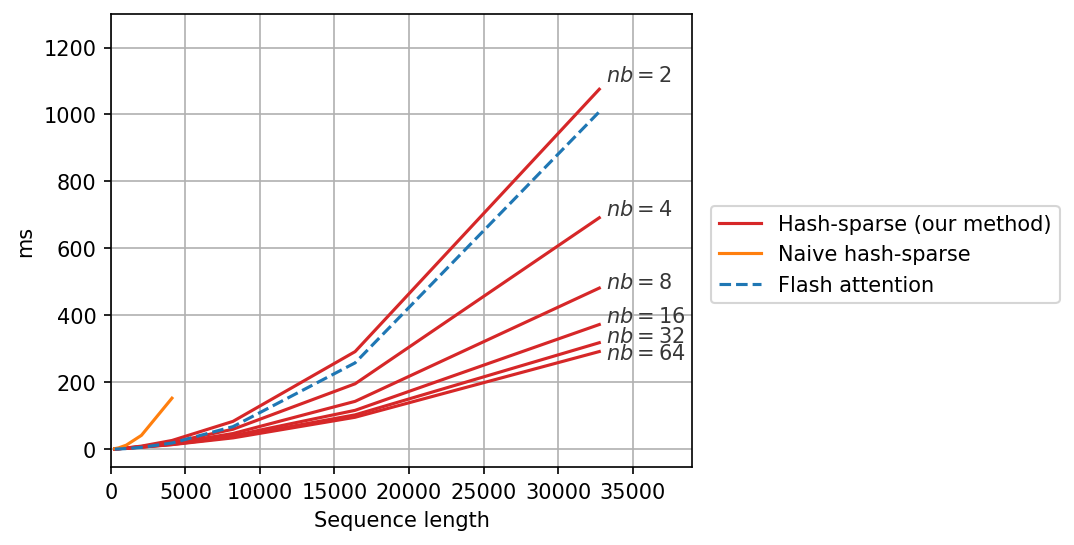

In [11]:

fig, (ax1) = plt.subplots(1, 1, figsize=(5,4), dpi=150)


ax1.grid()

us_q20 = np.array([x[0] for x in us_2])
us_median = np.array([x[1] for x in us_2])
us_q80 = np.array([x[2] for x in us_2])
ax1.plot(N_CTXs, us_median, label="Hash-sparse (our method)", color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 1100, '$nb=2$', color='#373737')

us_q20 = np.array([x[0] for x in us_4])
us_median = np.array([x[1] for x in us_4])
us_q80 = np.array([x[2] for x in us_4])
ax1.plot(N_CTXs, us_median, color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 700, '$nb=4$', color='#373737')

us_q20 = np.array([x[0] for x in us_8])
us_median = np.array([x[1] for x in us_8])
us_q80 = np.array([x[2] for x in us_8])
ax1.plot(N_CTXs, us_median, color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 480, '$nb=8$', color='#373737')

us_q20 = np.array([x[0] for x in us_16])
us_median = np.array([x[1] for x in us_16])
us_q80 = np.array([x[2] for x in us_16])
ax1.plot(N_CTXs, us_median, color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 380, '$nb=16$', color='#373737')

us_q20 = np.array([x[0] for x in us_32])
us_median = np.array([x[1] for x in us_32])
us_q80 = np.array([x[2] for x in us_32])
ax1.plot(N_CTXs, us_median, color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 320, '$nb=32$', color='#373737')

us_q20 = np.array([x[0] for x in us_64])
us_median = np.array([x[1] for x in us_64])
us_q80 = np.array([x[2] for x in us_64])
ax1.plot(N_CTXs, us_median, color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 270, '$nb=64$', color='#373737')

them_q20 = np.array([x[0] for x in them])
them_median = np.array([x[1] for x in them])
them_q80 = np.array([x[2] for x in them])

naive_hash_sparse = [1.63515737,   3.83146664,  11.83795198,  41.34331767, 152.38997396]
N_CTXs_ = [258, 512, 1024, 2048, 4096]
ax1.plot(N_CTXs_, naive_hash_sparse, label="Naive hash-sparse", color=tableau20[2])

ax1.plot(N_CTXs, them_median, label="Flash attention", color=tableau20[0], linestyle='--')
ax1.fill_between(N_CTXs, them_q20, them_q80, alpha=.5, linewidth=0, color=tableau20[1])

#ax1.legend(fontsize=10)#loc='center right', fontsize=10)
ax1.set_xlabel('Sequence length')
ax1.set_ylabel('ms')
ax1.set_ylim(ymax=1300)

ax1.set_xlim([0,39000])

ax1.legend(bbox_to_anchor=(1.65, 0.6), ncol=1)

plt.savefig(f"{mode}-hash-sparse-vs-full-flash.pdf", bbox_inches = 'tight')

## QK-Sparse

In [17]:
mode = 'fwd+bwd'

BATCH, H, D_HEAD = 4, 48, 64
N_CTXs = [258, 512, 1024, 2048, 4096, 8192, 16384, 32768]

us_20 = []
us_30 = []
us_40 = []
us_50 = []
us_60 = []
us_70 = []
us_80 = []
them = []

def sparse_attn(sparsity, n_ctx, mode='fwd'):
    q, k, v = get_tensors(BATCH, H, n_ctx, D_HEAD)
    q_keep = (torch.rand((BATCH, n_ctx, H), dtype=torch.bfloat16, device="cuda") > sparsity).float()
    k_keep = (torch.rand((BATCH, n_ctx, H), dtype=torch.bfloat16, device="cuda") > sparsity).float()
    sm_scale = 1.0 / math.sqrt(q.size(-1))
    fn = lambda: dynamic_sparse_attention(q, k, v, q_keep, k_keep, sm_scale=sm_scale, sparsity_mode='qk')
    if mode == 'fwd':
        return triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
    elif mode == 'bwd':
        o = fn()
        do = torch.randn_like(o)
        fn = lambda: o.backward(do, retain_graph=True)
        return triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
    else: # mode == 'fwd+bwd'
        q20_fwd, median_fwd, q80_fwd = triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
        o = fn()
        do = torch.randn_like(o)
        fn = lambda: o.backward(do, retain_graph=True)
        q20_bwd, median_bwd, q80_bwd = triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
        return q20_fwd+q20_bwd, median_fwd+median_bwd, q80_fwd+q80_bwd
    

def flash_attn(n_ctx, mode='fwd'):
    q, k, v = get_tensors(BATCH, H, n_ctx, D_HEAD)
    fn = lambda: flashattention(q, k, v)
    if mode == 'fwd':
        return triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
    elif mode == 'bwd':
        o = fn()
        do = torch.randn_like(o)
        fn = lambda: o.backward(do, retain_graph=True)
        return triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
    else: # mode == 'fwd+bwd'
        q20_fwd, median_fwd, q80_fwd = triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
        o = fn()
        do = torch.randn_like(o)
        fn = lambda: o.backward(do, retain_graph=True)
        q20_bwd, median_bwd, q80_bwd = triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
        return q20_fwd+q20_bwd, median_fwd+median_bwd, q80_fwd+q80_bwd


for n_ctx in N_CTXs:
    # test our method 
    sparsity = 0.2
    q20, median, q80 = sparse_attn(sparsity=sparsity, n_ctx=n_ctx, mode=mode)
    us_20.append((q20, median, q80))

    sparsity = 0.3
    q20, median, q80 = sparse_attn(sparsity=sparsity, n_ctx=n_ctx, mode=mode)
    us_30.append((q20, median, q80))

    sparsity = 0.4
    q20, median, q80 = sparse_attn(sparsity=sparsity, n_ctx=n_ctx, mode=mode)
    us_40.append((q20, median, q80))

    sparsity = 0.5
    q20, median, q80 = sparse_attn(sparsity=sparsity, n_ctx=n_ctx, mode=mode)
    us_50.append((q20, median, q80))

    sparsity = 0.6
    q20, median, q80 = sparse_attn(sparsity=sparsity, n_ctx=n_ctx, mode=mode)
    us_60.append((q20, median, q80))

    sparsity = 0.7
    q20, median, q80 = sparse_attn(sparsity=sparsity, n_ctx=n_ctx, mode=mode)
    us_70.append((q20, median, q80))

    sparsity = 0.8
    q20, median, q80 = sparse_attn(sparsity=sparsity, n_ctx=n_ctx, mode=mode)
    us_80.append((q20, median, q80))

    # test pytorch flash
    q20, median, q80 = flash_attn(n_ctx, mode=mode)
    them.append((q20, median, q80))


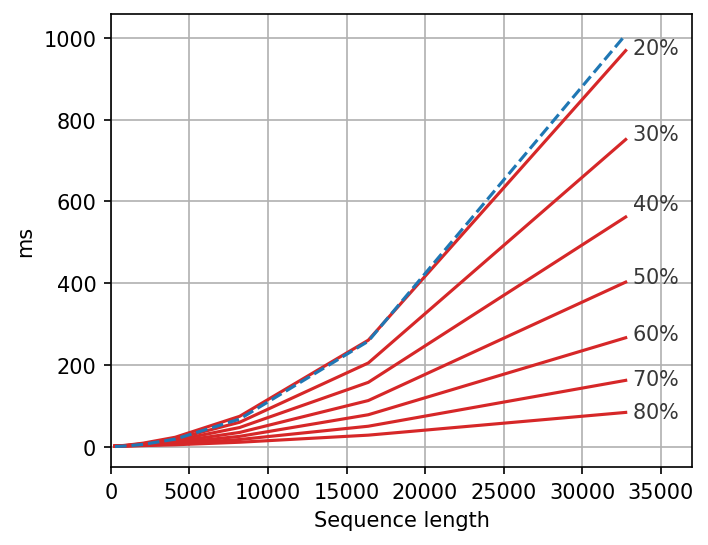

In [19]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5,4), dpi=150)

ax1.grid()

us_q20 = np.array([x[0] for x in us_20])
us_median = np.array([x[1] for x in us_20])
us_q80 = np.array([x[2] for x in us_20])
ax1.plot(N_CTXs, us_median, label="QK-sparse (our method)", color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 960, '$20\%$', color='#373737')

us_q20 = np.array([x[0] for x in us_30])
us_median = np.array([x[1] for x in us_30])
us_q80 = np.array([x[2] for x in us_30])
ax1.plot(N_CTXs, us_median, color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 750, '$30\%$', color='#373737')

us_q20 = np.array([x[0] for x in us_40])
us_median = np.array([x[1] for x in us_40])
us_q80 = np.array([x[2] for x in us_40])
ax1.plot(N_CTXs, us_median, color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 580, '$40\%$', color='#373737')

us_q20 = np.array([x[0] for x in us_50])
us_median = np.array([x[1] for x in us_50])
us_q80 = np.array([x[2] for x in us_50])
ax1.plot(N_CTXs, us_median, color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 400, '$50\%$', color='#373737')

us_q20 = np.array([x[0] for x in us_60])
us_median = np.array([x[1] for x in us_60])
us_q80 = np.array([x[2] for x in us_60])
ax1.plot(N_CTXs, us_median, color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 260, '$60\%$', color='#373737')

us_q20 = np.array([x[0] for x in us_70])
us_median = np.array([x[1] for x in us_70])
us_q80 = np.array([x[2] for x in us_70])
ax1.plot(N_CTXs, us_median, color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 150, '$70\%$', color='#373737')

us_q20 = np.array([x[0] for x in us_80])
us_median = np.array([x[1] for x in us_80])
us_q80 = np.array([x[2] for x in us_80])
ax1.plot(N_CTXs, us_median, color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 70, '$80\%$', color='#373737')

them_q20 = np.array([x[0] for x in them])
them_median = np.array([x[1] for x in them])
them_q80 = np.array([x[2] for x in them])

ax1.plot(N_CTXs, them_median, label="Flash attention", color=tableau20[0], linestyle='--')
ax1.fill_between(N_CTXs, them_q20, them_q80, alpha=.5, linewidth=0, color=tableau20[1])

ax1.set_xlabel('Sequence length')
ax1.set_ylabel('ms')

ax1.set_xlim([0,37000])

plt.savefig(f"{mode}-qk-sparse-vs-full-flash.pdf", bbox_inches = 'tight')